In [1]:
from itertools import repeat
from brian2 import *
import pandas as pd

In [2]:
# phase-locking LIF model:
# dv/dt = (-(v-Vr)+ R_m*I_e+o_a*sin(2*pi*o_f+p))/taum
#     V = membrane state
#     Vr = reset potential (E_l for LIF)
#     R_m = membrane resistance
#     I_e = input current
#     o_a = oscillation amplitude within the neuron (kept constant at 10 mV)
#     o_f = oscillation frequency within the neuron
#     p = phase of the neuron

In [356]:
def pl_lif_current(o_a,o_f,p,pv = False):
	# inputs:
        # o_a = amplitude of the neuron
        # o_f = frequency of the neuron
        # p = phase of the neuron
        # pv = plot voltage? by default is false
    # outputs:
		# fr = firing rate in Hz (spike time/total time)
		# cv = coefficient of variation
        # M.v = membrane voltage over time as an np.array
        # M.t = time as an np.array
    
    start_scope() # clear the workspace of previous Brian objects

	# parameters
    taum = 20*ms # time constant
    g_L = 10*nS # leak conductance
    R_m = 1/g_L # membrane resistance
    E_l = -70*mV # leak reversal potential (leak current)
    Vr = E_l # reset potential
    Vth = -50*mV # spike threshold

    # # neuron intrinsic properties # start with neuron subthreshold (not going to spike) - NOW DETERMINED BY FUNCTION INPUT
    # o_a = 10*mV # neuron oscillation amplitude # this seems to influence spiking
    # o_f = 0.2*Hz # neuron oscillation frequency # larger the number, larger fluctuations in membrane voltage
    # p = pi # neuron phase # influences where in the "cycle/period" the neuron starts at

    # oscillation current properties
    c_freq = 10*Hz # humans hear between 20 Hz and 20 kHz so our current should respect that
    amplitude = 2/10*nA
    
    # phase-locked LIF neuron equation (with refractory period - they did not specify if refractory in paper)
    # oscillation current input (sinusoidal wave - in paper it is a step current)
    eqs = '''
    dv/dt = (-(v - Vr) + R_m*(I_e)+o_a*sin(2*pi*t*o_f+p)) / taum : volt (unless refractory)
    I_e = amplitude*sin(2*pi*c_freq*t) : amp
    '''

	# set up the neuron
    N = NeuronGroup(1,model=eqs, threshold='v>Vth', reset='v=Vr', refractory='5*ms', method='euler')
    N.v = E_l # intialize it to it's resting potential

	# tell brian2 what to record from the simulation
    M = StateMonitor(N, ('v'), record=True ) # record potential changes
    S = SpikeMonitor(N) # record spikes
	
	# run the simulation
    sim_time = 1000*ms
    run(sim_time)

	# figure out oscillation current change over time
    x = M.t
    currChange = lambda t, amplitude, c_freq: eval(N.I_e.variable.expr)
    z = [currChange(t,amplitude,c_freq) for t in x]

    # plot oscillation current and neuron voltage on same plot if pv is true
    if pv == True:
        fix,ax = plt.subplots()
        ax.plot(x,z,color='#E1BE6A') # make plot
        ax.set_xlabel("time (s)") # set x-axis label
        ax.set_ylabel("V",color='#E1BE6A') # set y-axis label

        # use twinx() to create second axis object
        ax2 = ax.twinx()
        ax2.plot(x,M.v[0], color="#40B0A6")
        ax2.set_ylabel("mV",color="#40B0A6")
        plt.show()

	# calculate the firing rate in Hz
    fr = S.num_spikes/sim_time

	# calculate coefficient of variation
    ISIs = S.spike_trains()[0][1:]-S.spike_trains()[0][:-1]
    cv = np.std(ISIs)/np.mean(ISIs)
	
    # return values
    return fr,cv,asarray(M.v),asarray(M.t)

In [357]:
# We are looking at how amplitude and preferred frequency influence the membrane voltage and firing rate when in anti-phase and phase?

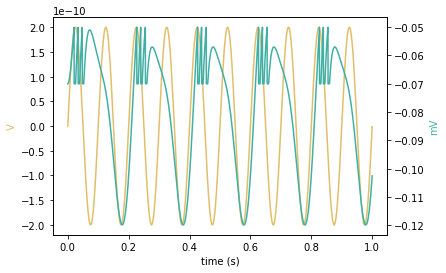

15. Hz


In [369]:
# firing out of phase with current input
    # amplitude of current = 2/10*nA, frequency of current = 5*Hz
fr,cv,m_volt,m_time = pl_lif_current(50*mV,5*Hz, p = 2*pi, pv = True)
print(fr)

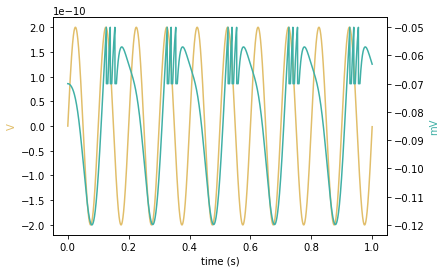

15. Hz


In [370]:
# firing out of phase with current input
    # amplitude of current = 2/10*nA, frequency of current = 5*Hz
fr,cv,m_volt,m_time = pl_lif_current(50*mV,5*Hz, p = pi, pv = True)
print(fr)

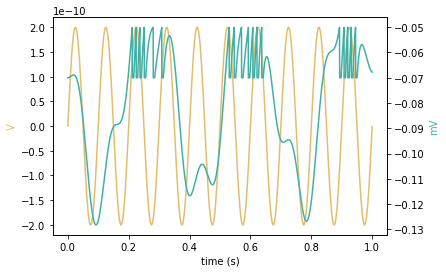

18. Hz


In [365]:
# firing out of phase with current input
    # amplitude of current = 2/10*nA, frequency of current = 5*Hz
fr,cv,m_volt,m_time = pl_lif_current(50*mV,3*Hz, p = pi, pv = True)
print(fr)

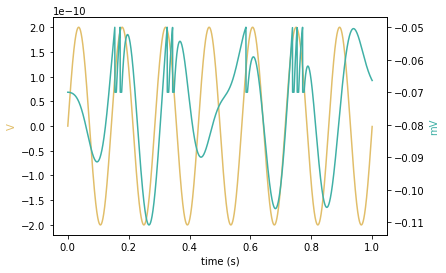

8. Hz


In [347]:
# firing out of phase with current input (current phase = 2pi, neuron phase = pi), both have the same frequency
    # clearly out of phase when the amplitude of the neuron is high... 
fr,cv,m_volt,m_time = pl_lif_current(30*mV,5*Hz, p = pi, pv = True)
print(fr)

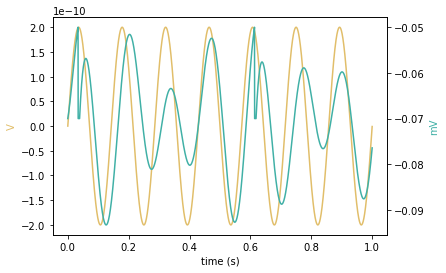

2. Hz


In [348]:
# firing out of phase with current input (current phas|e = 2pi, neuron phase = pi), both have the same frequency
    # when we decrease the amplitude of the neuron... it looks like it still nearly syncs up?
fr,cv,m_volt,m_time = pl_lif_current(10*mV,5*Hz, p = 2*pi+1, pv = True)
print(fr)

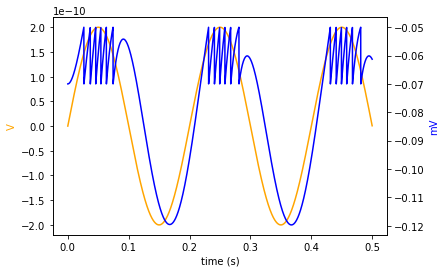

36. Hz


In [229]:
# firing anti-phase with current input
fr,cv,m_volt,m_time = pl_lif_current(38*mV,5*Hz, p = 2*pi, pv = True)
print(fr)

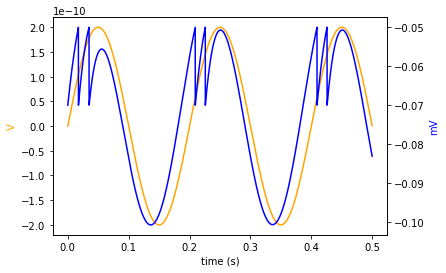

12. Hz


In [214]:
# firing anti-phase with current input
fr,cv,m_volt,m_time = pl_lif_current(30*mV,5*Hz, p = pi/2, pv = True)
print(fr)

In [179]:
# loop through different values for neuron intrinsic properties
n_amps = []
n_freq = []
n_fr = []

for o_a in linspace(20*mV,40*mV,20): # these values seem to be the sweet spot for firing rates
    n_amps.append(o_a/mV) # removes units
    for o_f in linspace(1*Hz,10*Hz,20):
        n_freq.append(o_f/Hz) # removes units
        fr,cv,m_volt,m_time = pl_lif_current(o_a = o_a, o_f = o_f, p = 1) # right now only using fr, but we can also get membrane voltage - that could be useful
        n_fr.append(fr/Hz) # removes units
        # print(fr)

In [180]:
n_amps = [x for item in n_amps for x in repeat(item, 20)]

In [181]:
# create df for our diff neuron properties simulation
neuron_df = pd.DataFrame({'Amplitude': n_amps,'Frequency': n_freq,'FiringRate': n_fr}) # pandas df
neuron_df = neuron_df.round(2)
neuron_df_p = neuron_df.pivot(index='Amplitude', columns='Frequency', values='FiringRate') # pivot table

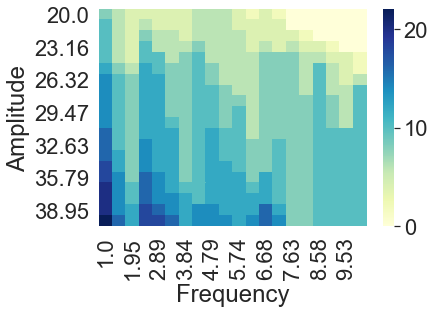

In [182]:
# import seaborn as sns
# sns.heatmap(neuron_df_p, cmap="YlGnBu").get_figure().savefig('fr_heatmap_.png',bbox_inches='tight')